# Training Potts Models with Contrastive Divergence for Protein Design

This notebook contains the "Nice to haves" for the project.

We begin by running the Potts model notebook on data for the neural cell adhesion molecule (NCAM) sequences. 

In [ ]:
!git clone https://github.com/igemto-drylab/CSBERG-ML.git
%cd CSBERG-ML
from util import *
import tqdm.notebook as tq
%cd ..

In [ ]:
plt.rcParams['figure.dpi'] = 350

In [ ]:
!git clone https://github.com/ranganathanlab/bmDCA.git

In [ ]:
!sudo apt-get update
!sudo apt-get install git gcc g++ automake autoconf pkg-config \
  libarmadillo-dev libopenblas-dev libarpack++2-dev

In [ ]:
%cd bmDCA
!bash autogen.sh --prefix=/usr/local && \
%cd ..

In [ ]:
%%shell
cd bmDCA
make -j4 && \
make install
cd ..

In [ ]:
!mkdir results

In [ ]:
%cd /content

In [1]:
import numpy as np
import torch
import torch.nn as nn
import tqdm.notebook as tq
import random
import seaborn as sns

from scipy.stats import gaussian_kde
from torch import optim
from torch.utils.data import DataLoader, Dataset
from util import *

In [2]:
class GREMLIN(torch.nn.Module):
    def __init__(self,L,A):
        super(GREMLIN, self).__init__()
        self.W0 = torch.nn.Parameter(torch.zeros(L*A,L*A), requires_grad=True)
        self.b0 = torch.nn.Parameter(torch.zeros(L*A), requires_grad=True)
        self.MASK = (1.0 -torch.eye(L*A)).to(device)

    def forward(self, X):
        X = X.reshape(-1,L*A)
        W = (self.W0+self.W0)/2.0 * self.MASK
   
        MSA_pred = (X.mm(W)+self.b0).reshape(-1,L,A)
        loss = torch.sum(- msa * F.log_softmax(MSA_pred, -1))
        L2_w = torch.square(W).sum() * 0.01 * 0.5 *L*A
        L2_b = torch.square(self.b0).sum() * 0.01
        loss = loss + L2_w + L2_b
        return loss

class Model(torch.nn.Module):
    def __init__(self,L,A):
        super(Model, self).__init__()
        self.GREMLIN_ = GREMLIN(L,A)
    
    def forward(self,X):
        loss = self.GREMLIN_(X)
        return loss

In [3]:
def read_fasta(fname, onehot=True):
    seqs = []
    seq_list = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    seqs.append(s)
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
        seqs.append(s)
        seq_list.append(list(s))
    if onehot:
        return get_X(seqs)
    else:
        return np.array(seqs)
        

def read_fasta_seqs(fname):
    seqs = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    seqs.append(list(s))
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
        seqs.append(list(s))
    return np.array(seqs)

In [4]:
L = 97 # sequence length
q = 21 # number of tokens  (this is 'A' in the GREMLIN code)

h = torch.from_numpy(np.random.randn(L*q)) # fields    (this is b0 in GREMLIN)
J = torch.from_numpy(np.random.randn(L*q, L*q)) # couplings (this is W0 in GREMLIN)


# compute the energy logexp(.) for a sequence s

def logE(s, h, J):
    """
    s: sequence
    h: fields vector (L*q)
    J: couplings matrix (L*q, L*q)
    """
    # compute indicies of s by adding to it [0, 0, 0, ... 21, 21, 21 ...]
    if not torch.is_tensor(s):
        s = torch.from_numpy(s)
    # print(s)
    # print(torch.linspace(0, q*(L-1), L))
    s_idx = s + torch.linspace(0, q*(L-1), L).type(torch.LongTensor).to(device)
    sum_h = torch.sum(h[s_idx])
    j_idx = torch.meshgrid(s_idx, s_idx)
    sum_J = torch.sum(J[j_idx])
    return -(sum_h + sum_J)

# convert list of M sequences of length L each into an MxL matrix of numbers in [0,20]

def seq2num(s):
    nums = []
    for aa in s:
        try:
            nums.append(AA_IDX[aa.upper()])
        except KeyError:
            return None
    return nums

def get_numerical_aas(fname):
    mat = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    aanums = seq2num(s)
                    if aanums is not None:
                        mat.append(aanums)
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
    return np.array(mat)

In [5]:
def trim_seqs(seqs, save_name):
    """
    seqs: sequences (list of letters not one-hot encoded)
    save_name: output fasta filename
    returns: mask (1 for kept positions, 0 for discarded positions)
    """
    mask = np.zeros(len(seqs[0]), dtype=np.bool)
    for i in range(len(seqs[0])):
        gaps = 0
        for s in seqs:
            if s[i] == '-':
                gaps += 1
        if gaps/len(seqs) < 0.67:   # keep positions where less than 2/3rd are gaps
            mask[i] = True
    seqs = seqs[:,mask]

    towrite = ""
    for i in range(len(seqs)):
        if sum(seqs[i][100:] == "-") < 50:  # don't take sequences with many gaps
            towrite += ">{}\n".format(i)
            seq = "".join(seqs[i][:]) + "\n"
            towrite += seq.upper()   
    with open(save_name,'w') as f:
        f.write(towrite)
    return mask

In [6]:
seqs = read_fasta_seqs("PF00041_seed.txt")
mask = trim_seqs(seqs, "PF00041_seed_short.fasta")

/Users/syedather/opt/anaconda3/envs/jpy3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [7]:
i = 0
j = 0
trim2ali = {} # maps index of trimmed sequence to index of aligned sequence
while j < len(mask):
    if mask[j] == 1:
        trim2ali[i] = j
        i += 1
    j += 1
print(trim2ali)

{0: 0, 1: 1, 2: 2, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 15, 12: 16, 13: 17, 14: 18, 15: 19, 16: 20, 17: 21, 18: 22, 19: 23, 20: 24, 21: 25, 22: 26, 23: 27, 24: 30, 25: 31, 26: 32, 27: 33, 28: 34, 29: 35, 30: 36, 31: 37, 32: 38, 33: 39, 34: 40, 35: 41, 36: 42, 37: 46, 38: 47, 39: 48, 40: 49, 41: 50, 42: 51, 43: 52, 44: 62, 45: 63, 46: 64, 47: 65, 48: 66, 49: 67, 50: 68, 51: 72, 52: 73, 53: 74, 54: 75, 55: 80, 56: 81, 57: 84, 58: 85, 59: 86, 60: 87, 61: 88, 62: 89, 63: 90, 64: 92, 65: 93, 66: 94, 67: 95, 68: 96, 69: 97, 70: 98, 71: 99, 72: 100, 73: 101, 74: 102, 75: 104, 76: 105, 77: 106, 78: 107, 79: 108, 80: 109, 81: 112, 82: 113, 83: 114, 84: 115, 85: 116}


In [8]:
# map index of aligned sequence to residue index on the protein structure
aligned = """------------------------------------------------------------
------------------------------------------------------------
-----------------------------------------------AGTV------Y-Y
-PTNAG------GTVG-A--I----A-------I-------V---------P--------
-G--------Y---------T--------A-RQ-----------------SS---I---K
----W----W-------G----P-----R---------L------A-----S--------
H-----G------------F---------V--V---I-------T---------I---D-
-------T---N---S---TLD--------------------------------------
----------------------QP-S---S---R---S--S---Q----Q----M-----
A----A-----L---------R-------Q----V--------A-------S------L-
--------N---------------------------------------G---T---S--S
S-----------------------------------------------------------
----------P------I------Y------G-------K---------V----------
---D--------------T----------A------R-----M------G--V---M-G-
--------W---S-------M-----------G--------G---------G------G-
--------S-----------L-------------I-----------S-------------
---A----------------A---------------N---------------N-------
--P---------------S---------------L--------------K----------
--A----------A-------------A---------P---------Q------A-P---
------------------------------------------------------------
---W--D--S-----S----T-----N-----F------S-----S------V-------
-T--------V------P-----T-------L---I-----F--A-C---E--N------
--D--S---I---A--P----V---N--S------------------------S-A-L--
-PI--------Y-------D--------S------M--------------------S---
-------R------------------N-----------A----------K----------
Q------F--------L-------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
-----------------EINGGSHSCANSGNSNQALIGKKGVAWMKRFM-----------
------------------------------------------------------------
--------------------------------""".replace('\n','')

short = """--AGTV----YYPTNAGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVV
ITIDTNSTLDQPSSRSSQQMAALRQVASLN----GTSSS-------PIYGKVDTARMGVM
GWSMGGGGSLISAANNPSLKAAAPQAP---WDSSTNFSSVTVPTLIFACENDSIAPVNSS
ALIYDSM-SRNAKQFL---------------------------------------EIN""".replace('\n','')

protein = """MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRPS
GYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQPS
SRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAP
QAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCAN
SGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCSLEHHHHHH""".replace('\n','')

ali2prot = {}
i = 0
j = 65 - 1
while i < len(aligned):
    if aligned[i] != "-":
        if aligned[i] == protein[j]:
            ali2prot[i] = j + 1
            j += 1
        else:
            raise KeyError
    i += 1
print(ali2prot)

{167: 65, 168: 66, 169: 67, 170: 68, 177: 69, 179: 70, 181: 71, 182: 72, 183: 73, 184: 74, 185: 75, 192: 76, 193: 77, 194: 78, 195: 79, 197: 80, 200: 81, 205: 82, 213: 83, 221: 84, 231: 85, 241: 86, 250: 87, 260: 88, 269: 89, 271: 90, 272: 91, 290: 92, 291: 93, 295: 94, 299: 95, 304: 96, 309: 97, 317: 98, 322: 99, 328: 100, 338: 101, 345: 102, 351: 103, 360: 104, 366: 105, 379: 106, 389: 107, 392: 108, 396: 109, 404: 110, 414: 111, 418: 112, 427: 113, 431: 114, 435: 115, 439: 116, 440: 117, 441: 118, 502: 119, 503: 120, 505: 121, 509: 122, 513: 123, 517: 124, 520: 125, 524: 126, 529: 127, 534: 128, 540: 129, 545: 130, 551: 131, 561: 132, 569: 133, 574: 134, 583: 135, 591: 136, 598: 137, 608: 138, 648: 139, 652: 140, 656: 141, 659: 142, 660: 143, 730: 144, 737: 145, 744: 146, 751: 147, 759: 148, 769: 149, 783: 150, 798: 151, 809: 152, 816: 153, 822: 154, 829: 155, 832: 156, 836: 157, 838: 158, 848: 159, 852: 160, 860: 161, 872: 162, 881: 163, 891: 164, 898: 165, 908: 166, 920: 167, 934:

In [9]:
idx = np.array(list(trim2ali.values())).astype(np.int)
ali = np.array(list(aligned))
print("".join(list(ali[idx])))

--------------------------------------------------------------------------------------


/Users/syedather/opt/anaconda3/envs/jpy3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [10]:
msa = read_fasta("PF00041_seed.txt")
print(msa.shape)
N, L, A = msa.shape
msa = torch.from_numpy(msa)
msa = msa.type(torch.FloatTensor).to(device)

(98, 117, 21)


In [11]:
def map_index(l):
    """
    l: list of indices of the trimmed sequences
    returns: corresponding protein structure indices
    """
    idx = []
    for i in l:
        try:
            idx.append(ali2prot[trim2ali[i]])
        except KeyError:
            idx.append(0)
    return idx

In [12]:
beta_carbons = []
with open("CSBERG-ML/1gfp_h.pdb", 'r') as f:
    line = f.readline()
    line = f.readline()
    while line:
        data = line.split()
        if data[2] == 'CB' or data[2] == 'HA1':
            beta_carbons.append([float(data[6]), float(data[7]), float(data[8])])
        line = f.readline()

coords = np.array(beta_carbons[1:])
dists = np.zeros((len(coords), len(coords)))
for i, curr in enumerate(coords):
    dists[:,i] = np.linalg.norm(coords - curr, axis=1)

In [13]:
def get_precision(L2, L5):
    for l in [L2, L5]:
        p = 0
        a = map_index(list(l.flatten()))
        a = np.array(a).reshape(-1,2) - 29 # structure index starts at 29
        for row in a:
            if row[0] != 0 and row[1] != 0:
                if dists[row[0], row[1]] < 8.0:
                    p += 1
        print(p/len(L2))

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model(L, A).to(device)
learning_rate = 0.1*np.log(N)/L
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

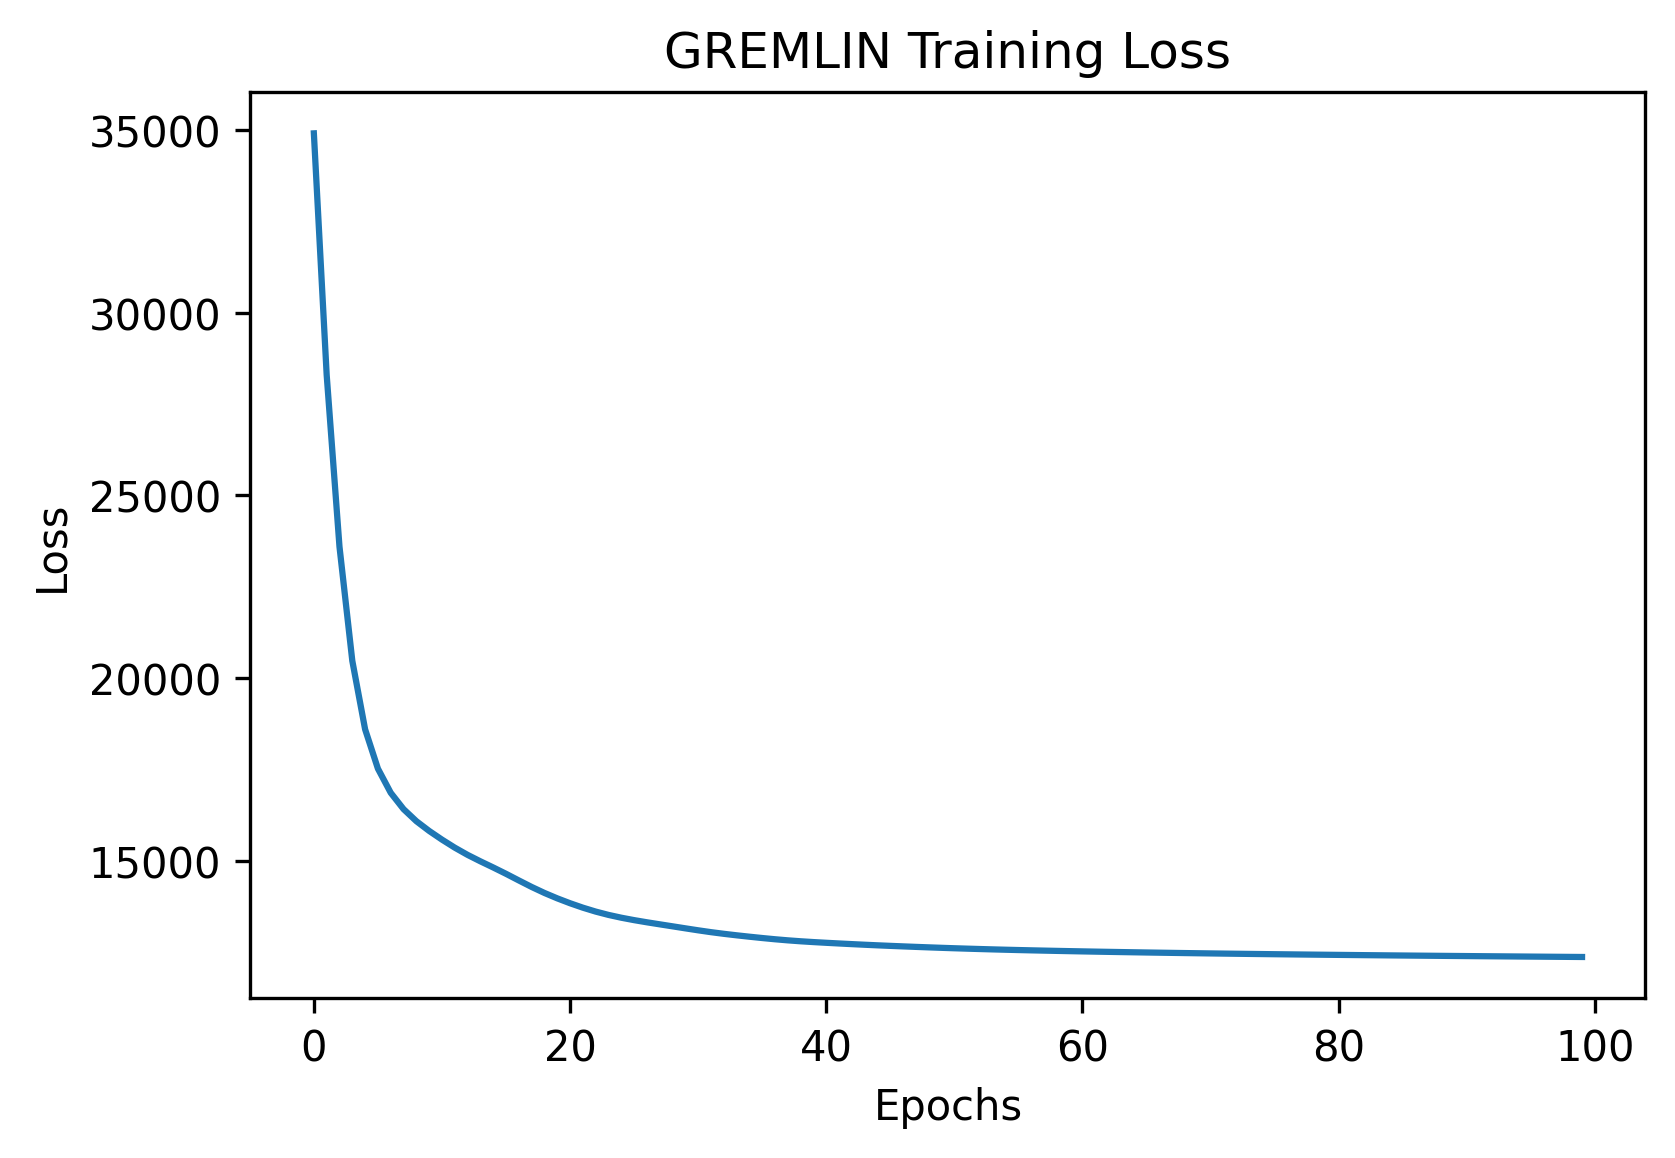

In [15]:
losses = []
for t in tq.tqdm(range(100)):
    loss = model(msa)      
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("GREMLIN Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [16]:
w = model.GREMLIN_.W0.cpu().detach().numpy()
w = (w+w.T).reshape(L,A,L,A)
h = model.GREMLIN_.b0.cpu().detach().numpy()
np.save("gremlin_h_ncam.npy", h)
np.save("gremlin_J_ncam.npy", w)

def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:,:,:]),(1,3)))
  np.fill_diagonal(raw,0)
  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  return(raw,apc)

In [17]:

def get_contacts(w, showContacts=True):
    """
    w:            (L, 21, L, 21) numpy array corresponding to the J parameter
    showContacts: When True, shows the couplings matrix before and after APC
    """
    raw, apc = get_mtx(w)
    raw_copy = np.copy(raw)
    apc_copy = np.copy(apc)
    for i in range(len(apc)):
        for j in range(len(apc)):
            if abs(i-j) < 7:
                apc_copy[i,j] = 0
                raw_copy[i,j] = 0
    if showContacts:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(raw_copy)
        plt.grid(False)
        plt.title("Before APC")
        plt.xlabel("Residue Index")
        plt.ylabel("Residue Index")
        plt.subplot(1,2,2)
        plt.imshow(apc_copy)
        plt.xlabel("Residue Index")
        plt.grid(False)
        plt.title("After APC")
        plt.show()
    apc_copy = (apc_copy - np.min(apc_copy))/(np.max(apc_copy) - np.min(apc_copy))
    strengths = {}
    for i in range(len(apc)):
        for j in range(i, len(apc)):
            strengths[(i,j)] = apc_copy[i,j] 
    contacts = list(strengths.keys())
    contacts = sorted(contacts, key=lambda x: strengths[x], reverse=True)
    for i in range(len(contacts)):
        contacts[i] = list(contacts[i])
    L_2 = np.array(contacts[:int(len(apc) / 2)])    # @L/2
    L_5 = np.array(contacts[:int(len(apc) / 5)])    # @L/5
    return L_2, L_5

L2, L5 = get_contacts(w, showContacts=False)


In [18]:
model = Model(L,A).to(device)

h = model.GREMLIN_.b0.detach()
J = model.GREMLIN_.W0.detach()
J = (J + J.T)

In [19]:
in_dist = get_numerical_aas("PF00041_seed.txt")
out_dist1 = torch.from_numpy(np.array([np.random.permutation(s) for s in in_dist])).to(device)
out_dist2 = torch.from_numpy(np.array([np.concatenate((s[int(L/2):], s[:int(L/2)])) for s in in_dist])).to(device)
in_dist = torch.from_numpy(in_dist).to(device)

in_ratios = []
out_ratios = []
in_out1_ratios = []
in_out2_ratios = []
for i in tq.tqdm(range(len(in_dist)-1)):
    in_out1_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist1[i], h, J).item())
    in_out2_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist2[i], h, J).item())
    in_ratios.append(logE(in_dist[i], h, J).item() - logE(in_dist[i+1], h, J).item())
    out_ratios.append(logE(out_dist1[i], h, J).item() - logE(out_dist1[i+1], h, J).item())

  0%|          | 0/96 [00:00<?, ?it/s]

In [20]:
def get_fp(inin, inout):
    """
    Returns the false positive score as the overlapping area of the 
    In/Out vs. In/In distributions
    """
    x0 = np.array(inout)
    x1 = np.array(inin)
    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)

    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    print("False positive score: ", np.trapz(inters_x, x)/np.trapz(kde1_x, x))

In [21]:
get_fp(in_ratios, in_out2_ratios)


LinAlgError: singular matrix